# HCAS R notebook 03: PPR vs. GDM

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 20 May 2016

**Note**: this notebook can also be viewed at https://github.com/eric542/hcas

## Summary

This notebook simply re-generates the main results obtained in the first and second notebooks in this series. It simply shows the RS vs. (transformed) ENV distance plots side-by-side for GDM and PPR, for ease of comparison.

The PPR results shown in this notebook were obtained using all available "training" data (422,323 sites, 986,549 pairs) using Friedman's "supersmoother" function with a `bass` factor of 1, and a total of 19 ridge terms.

## Miscellaneous

Some preliminary `R` functions and definitions.

In [1]:
# function for plotting a colorbar in plots:
cbar = function(cmin,cmax,color_pal,ytxt="") {
    orig_mar = par("mar"); cbar_mar = c(orig_mar[1]+1,0.1,orig_mar[3]+1,3.7)
    par(mar=cbar_mar)
    tmp = seq(cmin,cmax,len=100)
    colsurf = matrix(c(tmp,tmp), nrow=2, byrow=TRUE)
    image(c(1,2), tmp, colsurf, col=color_pal, xlim=c(1,2), ylim=c(cmin,cmax), yaxt="n", xaxt="n", xlab="", ylab="")
    box(); axis(4); mtext(side=4, line=2.2, ytxt, cex=.75)
    par(mar=orig_mar)   # reset original parameters for other plots
}

In [2]:
library(repr)
suppressWarnings( library(gplots, warn=FALSE) )   # for hist2d()
cmap = c("#FFFFFF",topo.colors(250))
n_bins = 100
base_path = "//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/"

## PPR vs. GDM distance plots

In [3]:
# GDM results:
load(paste(base_path,"hcas_dist_GDMenv.Rdata",sep=''))
load(paste(base_path,"hcas_dist_RSpca9.Rdata",sep=''))

# PPR results:
load( paste(base_path,'hcas_eda05_PPR_subs1_scaledENV_nTerms19_supsmu_bass1_dist.Rdata',sep='') )

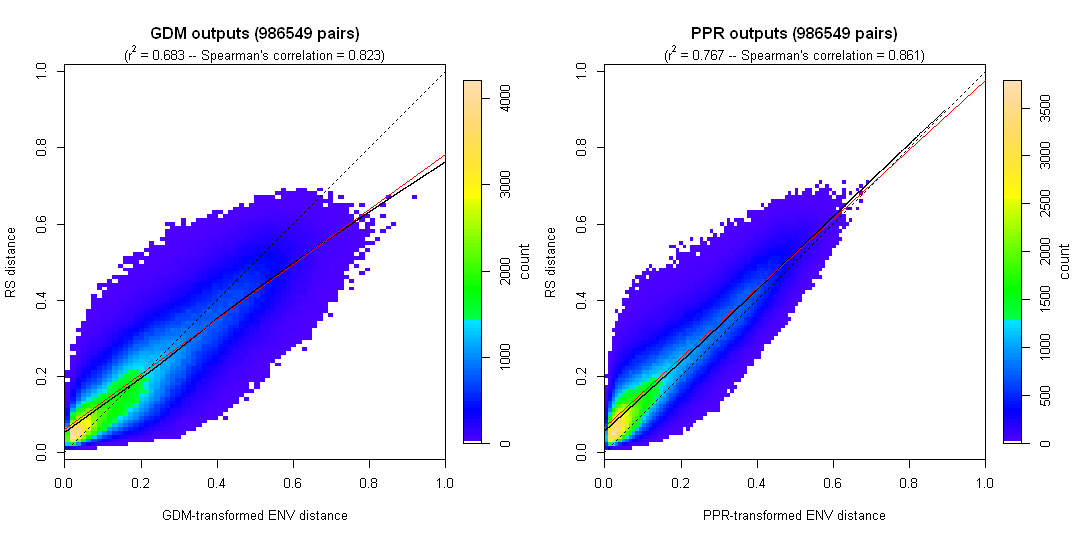

In [4]:
options(repr.plot.width=9, repr.plot.height=4.5)
layout(matrix(1:4,nrow=1), widths=c(10,1.7,10,1.7))
par(mar=c(5.1,4.1,4.1,1))

###########################
# GDM results:
n_pairs = length(env_dist_NonZeroPCA)

# histogram of distances:
tmp = hist2d( env_dist_NonZeroPCA, rsm_dist_NonZeroPCA, nbins=c(n_bins,n_bins), 
              col=cmap, ylim=c(0,1), xlim=c(0,1), asp=1 )
title( xlab="GDM-transformed ENV distance", ylab="RS distance", 
       main=paste("GDM outputs (",n_pairs," pairs)",sep='') ); box()

# LM and polynomial fits:
abline(0,1,lty=3)
lines(lowess(env_dist_NonZeroPCA, rsm_dist_NonZeroPCA), col="black")
GDMlm_out = lm(rsm_dist_NonZeroPCA~env_dist_NonZeroPCA)
abline(GDMlm_out, col="red")

# correlation coefficients:
r2 = round(summary(GDMlm_out)$r.squared,3)
cc = round(cor(rsm_dist_NonZeroPCA, env_dist_NonZeroPCA, method='spearman'),3)
title( main=bquote(paste('(',r^2,' = ',.(r2)," -- Spearman's correlation = ",.(cc),')',sep='')), 
       line=0.75, font.main=1, cex.main=1 )

cbar(0, max(tmp$count,na.rm=T), color_pal=cmap, 'count')

###########################
# PPR results:
n_pairs = length(PPRenv_dist)

# histogram of distances:
tmp = hist2d(PPRenv_dist, rsm_dist, nbins=c(n_bins,n_bins), 
             col=cmap, ylim=c(0,1), xlim=c(0,1), asp=1 ); box()
title( xlab="PPR-transformed ENV distance", ylab="RS distance", 
       main=paste("PPR outputs (",length(rsm_dist)," pairs)",sep='') )


# LM and polynomial fits:
abline(0,1,lty=3)
lines(lowess(PPRenv_dist, rsm_dist), col="black")
PPRlm_out = lm(rsm_dist~PPRenv_dist)
abline(PPRlm_out, col="red")

# correlation coefficients:
r2 = round(summary(PPRlm_out)$r.squared,3)
cc = round(cor(rsm_dist,PPRenv_dist,method='spearman'),3)
title( main=bquote(paste('(',r^2,' = ',.(r2)," -- Spearman's correlation = ",.(cc),')',sep='')), 
       line=0.75, font.main=1, cex.main=1 )

cbar(0, max(tmp$count,na.rm=T), color_pal=cmap, 'count')

Comparing the $r^2$ or Spearman correlation values, we can see that the PPR approach achieves a better correlation between the RS distances and (transformed) ENV distances.

Also, we can see that there is some residual bias with both the GDM and PPR approaches. PPR however seems to be better at reducing it than GDM (visually).

The fitted coefficients of the above distance relationships (LM fit) are as follows:

In [5]:
# GDM results:
print( t(t(capture.output(summary(GDMlm_out))[10:12])) )

     [,1]                                                           
[1,] "                     Estimate Std. Error t value Pr(>|t|)    "
[2,] "(Intercept)         0.0598509  0.0001507   397.1   <2e-16 ***"
[3,] "env_dist_NonZeroPCA 0.7238537  0.0004964  1458.3   <2e-16 ***"


In [6]:
# PPR results
print( t(t(capture.output(summary(PPRlm_out))[10:12])) )

     [,1]                                                   
[1,] "             Estimate Std. Error t value Pr(>|t|)    "
[2,] "(Intercept) 0.0645515  0.0001221   528.6   <2e-16 ***"
[3,] "PPRenv_dist 0.9133001  0.0005067  1802.4   <2e-16 ***"


While the intercept of the PPR relationship is slightly higher than that of the GDM, the estimated slope coefficient is much closer to 1 (1:1 relationship).